In [1]:
import numpy as np
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [2]:
# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

# Adjusting the labels
y_train_valid -= 769
y_test -= 769

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=42)

In [4]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:550]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y

def preprocess_data(X, y=None, sub_sample=2, average=2, noise_level=0.5, apply_noise=True):
    # Trim the data
    X = X[:,:,0:550]  # (sample, 22, 800)
    
    # Maxpool the data
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    if apply_noise:
        # Add noise to the training data
        X_max += np.random.normal(0.0, noise_level, X_max.shape)

        # If labels are provided, replicate them for augmented data
        if y is not None:
            y = np.tile(y, sub_sample)
    
    return X_max, y

In [5]:
import random
import tensorflow as tf
random.seed(12345)
np.random.seed(27)
tf.random.set_seed(145)

In [6]:
X_test_prep, _ = preprocess_data(X_test, sub_sample=2, average=2, noise_level=0.5, apply_noise=False)
y_test_prep = tf.keras.utils.to_categorical(y_test, 4)

# # Reshape the test data to match the model input
X_test_prep = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)

# # Swap axes to match the model input shape (None, 400, 1, 22)
X_test_prep = np.swapaxes(X_test_prep, 1, 3)
X_test_prep = np.swapaxes(X_test_prep, 1, 2)


print('Shape of test set:', X_test_prep.shape)
print('Shape of test labels after categorical conversion:', y_test_prep.shape)

Shape of test set: (443, 275, 1, 22)
Shape of test labels after categorical conversion: (443, 4)


In [7]:
# Preprocess the training and validation data
X_train_prep, y_train_prep = train_data_prep(X_train,y_train,2,2,True)
X_valid_prep, y_valid_prep = preprocess_data(X_valid, y_valid, apply_noise=False)

# One-hot encode the labels
y_train_prep = tf.keras.utils.to_categorical(y_train_prep, 4)
y_valid_prep = tf.keras.utils.to_categorical(y_valid_prep, 4)

# # Reshape the data to match the model input
X_train_prep = X_train_prep.reshape(X_train_prep.shape[0], X_train_prep.shape[1], X_train_prep.shape[2], 1)
X_valid_prep = X_valid_prep.reshape(X_valid_prep.shape[0], X_valid_prep.shape[1], X_valid_prep.shape[2], 1)

# # Swap axes to match the model input shape (None, 400, 1, 22)
X_train_prep = np.swapaxes(X_train_prep, 1, 3)
X_train_prep = np.swapaxes(X_train_prep, 1, 2)
X_valid_prep = np.swapaxes(X_valid_prep, 1, 3)
X_valid_prep = np.swapaxes(X_valid_prep, 1, 2)

print('Shape of training set:', X_train_prep.shape)
print('Shape of training labels:',y_train_prep.shape)
print('Shape of validation set:', X_valid_prep.shape)
print('Shape of validation labels:',y_valid_prep.shape)

Shape of X after trimming: (1903, 22, 550)
Shape of X after maxpooling: (1903, 22, 275)
Shape of X after averaging+noise and concatenating: (3806, 22, 275)
Shape of X after subsampling and concatenating: (7612, 22, 275)
Shape of Y: (7612,)
Shape of training set: (7612, 275, 1, 22)
Shape of training labels: (7612, 4)
Shape of validation set: (212, 275, 1, 22)
Shape of validation labels: (212, 4)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, MaxPooling1D, GRU, Conv1D, Reshape, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [10]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(275,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 275, 1, 25)     │         5,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 92, 1, 25)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 92, 1, 25)      │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 92, 1, 25)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 92, 1, 50)      │        12,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 1, 50)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 31, 1, 50)      │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 31, 1, 50)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 31, 1, 100)     │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 1, 100)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 11, 1, 100)     │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 11, 1, 100)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 1, 200)     │       200,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 1, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 1, 200)      │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 1, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         3,204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,079 (1.04 MB)

 Trainable params: 272,329 (1.04 MB)

 Non-trainable params: 750 (2.93 KB)

In [15]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = Adam(learning_rate=learning_rate)

In [16]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(X_train_prep,
             y_train_prep,
             batch_size=64,
             epochs=epochs,
             validation_data=(X_valid_prep, y_valid_prep), verbose=True)



Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.2962 - loss: 2.1288 - val_accuracy: 0.3962 - val_loss: 1.3793
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.3606 - loss: 1.5599 - val_accuracy: 0.4623 - val_loss: 1.2016
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.4454 - loss: 1.3360 - val_accuracy: 0.4953 - val_loss: 1.1664
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.5029 - loss: 1.1896 - val_accuracy: 0.5189 - val_loss: 1.1252
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.5432 - loss: 1.0952 - val_accuracy: 0.5142 - val_loss: 1.0629
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.5784 - loss: 1.0251 - val_accuracy: 0.5519 - val_loss: 1.0234
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.5979 - loss: 0.9784 - val_accuracy: 0.5991 - val_loss: 0.9580
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6222 - loss: 0.9012 - val_accu

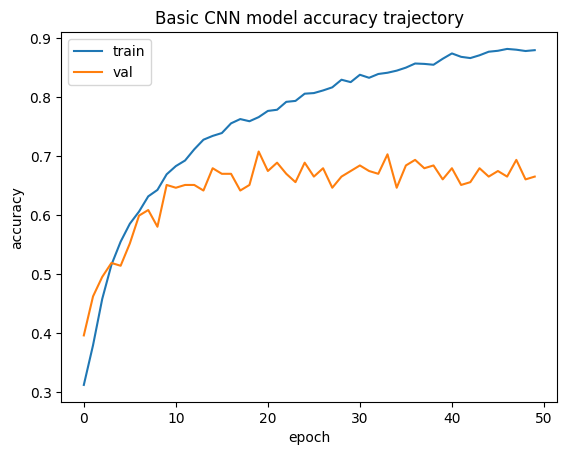

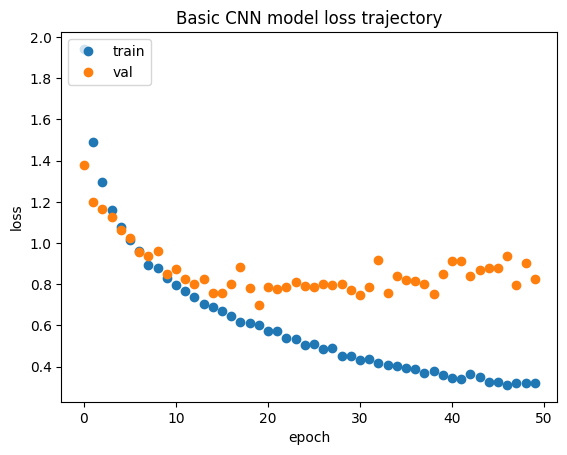

In [19]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(X_test_prep, y_test_prep, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7088035941123962
